In [1]:
import numpy as np
import matplotlib.pyplot as plt
#Prevent scientific notation
np.set_printoptions(suppress=True)
import pandas as pd

In [2]:
#Load the dataset and seperate the target colum
df = pd.read_csv('Absenteeism/Absenteeism_at_work.csv', delimiter=';')
#df = pd.read_csv('Absenteeism/Absenteeism_at_work_editted.csv')
#df = df.iloc[:20,:]
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()
df

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,11,14,7,3,1,289,36,13,33,264.604,...,0,1,2,1,0,1,90,172,30,8
736,1,11,7,3,1,235,11,14,37,264.604,...,0,3,1,0,0,1,88,172,29,4
737,4,0,0,3,1,118,14,13,40,271.219,...,0,1,1,1,0,8,98,170,34,0
738,8,0,0,4,2,231,35,14,39,271.219,...,0,1,2,1,0,2,100,170,35,0


In [3]:
class DecisionTreeRegressor:
    def __init__(self, min_rows=5):
        self.min_rows = min_rows

    #Calculate the residual sum of squares for vector v
    def _calc_rss(self,v):
        v_sorted = np.sort(v)
        len_v = len(v_sorted)
        totals = []
        for i in range(len_v-1):
            mean = np.mean(v_sorted[i:i+1])
            mean_left = np.mean(v_sorted[0:i+1])
            mean_right = np.mean(v_sorted[i+1:len_v])
            rss_left = np.sum((v_sorted[0:i+1]-mean_left) ** 2)
            rss_right = np.sum((v_sorted[i+1:len_v]-mean_right) ** 2)
            totals.append(rss_left + rss_right)
        return v_sorted, np.array(totals)

    #Get the value for the minimum rss
    def _min_rss(self,X):
        vals, rss = self._calc_rss(X)
        minrss = np.min(rss)
        idx = vals[np.where(rss==minrss)][0]
        count = len(X[X==idx])
        return idx,count,minrss

    #Get the feature that produce the best split
    def _best_feature_to_split(self,X):
        feature = None
        cutoff = None
        rss = None
        #Calculate the mean of  the last column (target)
        value = np.mean(X[:,-1])
        #Calculate the min rss for all features
        #Exclude the target column
        for i in range(X.shape[1]-1):
            idx, count, minrss = self._min_rss(X[:,i])
            #Only split the feature if there are different values for the feature
            if (X.shape[0] > count):
                if feature==None:
                    feature = i
                    cutoff = idx
                    rss = minrss
                elif (minrss<rss):
                    feature = i
                    cutoff = idx
                    rss = minrss
        return feature,cutoff,value

    def _split(self,frame):
        left_branch = right_branch = name = None
        feature, cutoff, value = self._best_feature_to_split(frame.to_numpy())
        if feature is not None:
            name = frame.columns[feature]
            left_branch = frame.loc[frame.iloc[:,feature]<=cutoff]
            right_branch = frame.loc[frame.iloc[:,feature]>cutoff]
        return feature, name, cutoff, value, left_branch, right_branch
        
    def fit(self, frame):
        if (frame.shape[0] < self.min_rows):
            return {None}
        feature, name, cutoff, value, left, right = self._split(frame)
        if (feature is None):
            return {None}
        else:
            node = {'feature': feature, 'name': name, 'cutoff': cutoff, 'value': value}
            node['left_node'] = self.fit(left)
            node['right_node'] = self.fit(right)
        self.nodes = node
        return node
    
    def predict(self, frame):
        y_pred = []
        for i in range(frame.shape[0]):
                                                    #Leave the target (last column) out
            y_pred.append(self._run_tree(self.nodes, frame.iloc[i,:-1]))
        return np.array(y_pred, dtype=np.int64)
    
    def _run_tree(self, node, frame):
        feature = node['feature']
        name = node['name']
        cutoff = node['cutoff']
        value = node['value']
        left_node = node['left_node']
        right_node = node['right_node']
        if left_node == {None} and right_node == {None}:
            return value
        if frame[name]>cutoff:
            if right_node == {None}:
                return value
            else:
                return self._run_tree(right_node,frame)
        else:
            if left_node == {None}:
                return value
            else:
                return self._run_tree(left_node,frame)
            
    def get_nodes(self):
        return self.nodes

In [4]:
model = DecisionTreeRegressor()
nodes = model.fit(df)
nodes

{'feature': 11,
 'name': 'Disciplinary failure',
 'cutoff': 0.0,
 'value': 6.924324324324324,
 'left_node': {'feature': 14,
  'name': 'Social drinker',
  'cutoff': 0.0,
  'value': 7.32,
  'left_node': {'feature': 15,
   'name': 'Social smoker',
   'cutoff': 0.0,
   'value': 6.182410423452769,
   'left_node': {'feature': 12,
    'name': 'Education',
    'cutoff': 1.0,
    'value': 6.140287769784172,
    'left_node': {'feature': 16,
     'name': 'Pet',
     'cutoff': 1.0,
     'value': 6.288043478260869,
     'left_node': {'feature': 16,
      'name': 'Pet',
      'cutoff': 0.0,
      'value': 7.520833333333333,
      'left_node': {'feature': 7,
       'name': 'Service time',
       'cutoff': 7.0,
       'value': 6.046875,
       'left_node': {'feature': 1,
        'name': 'Reason for absence',
        'cutoff': 7.0,
        'value': 3.857142857142857,
        'left_node': {None},
        'right_node': {'feature': 4,
         'name': 'Seasons',
         'cutoff': 1.0,
         'value': 3

In [5]:
from sklearn.metrics import r2_score
y_pred = model.predict(df)
print(r2_score(y, y_pred))

0.2069778225361676


In [6]:
import random

In [7]:
class RandomForestRegressor():
    def __init__(self, n_estimators=1000, random_state=0, bag_features=4):
        self.n_estimators = n_estimators
        np.random.RandomState = random_state
        self.bag_features = bag_features
    
    def _bootstrapX(self,X):
        bx = []
        bX = []
        for i in range(X.shape[0]):
            b = X.iloc[np.random.randint(X.shape[0]),:]
            bX.append(b)
        return pd.DataFrame(bX)
    
    def _bagX(self,X):
        #Do not select target column
        num_cols = X.shape[1]
        columns = random.sample(range(num_cols-1),self.bag_features)
        #re-append target column
        columns.append(num_cols-1)
        return X.iloc[:,columns]
    
    def fit(self, frame):
        self.trees = []
        for i in range(self.n_estimators):
            #print(i)
            bootstrapX = self._bootstrapX(frame)
            bagX = self._bagX(bootstrapX)
            #print(bagX)
            try:
                tree = DecisionTreeRegressor()
                tree.fit(bagX)
                self.trees.append(tree)
            except:
                pass
        print ('Trees generated: ' + str(len(self.trees)))
        return
    
    def predict(self, frame):
        y_preds = []
        models = [dt for dt in self.trees]
        nodes = [model.get_nodes() for model in models]
        for model in models:
            y_pred = model.predict(df)
            y_preds.append(y_pred)
        mean_y_preds = np.mean(y_preds, axis=0, dtype=np.int64)
        return mean_y_preds
    
    def get_trees(self):
        return self.trees

rf = RandomForestRegressor(n_estimators=10)
rf.fit(df)

Trees generated: 10


0.23462536141192414


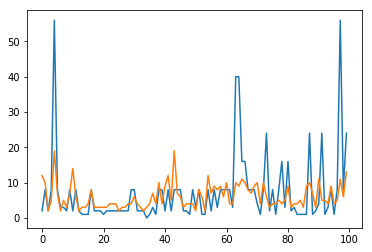

In [8]:
from sklearn.metrics import r2_score
y_pred = rf.predict(df)
print(r2_score(y, y_pred))
plt.plot(y[100:200])
plt.plot(y_pred[100:200])

In [4]:
import sklearn.ensemble as en
rf2 = en.RandomForestRegressor(n_estimators=10)
rf2.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

0.8036356415836118


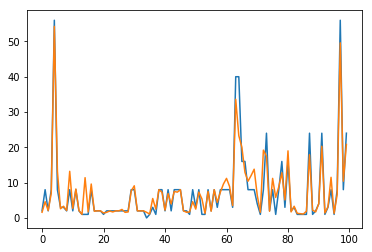

In [5]:
from sklearn.metrics import r2_score
y_pred = rf2.predict(X)
print(r2_score(y, y_pred))
plt.plot(y[100:200])
plt.plot(y_pred[100:200])